# Streaming k-means

This is an illustrative example of streaming k-means as implemented in Apache spark.
Note that this must be executed on the spark-master container itself because it requires direct access via the SparkContext.

In [21]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
sc = SparkContext('spark://spark-master:7077', 'streaming-k-means').getOrCreate()
# alternatively, you can use local (still in container) execution for testing (just does not use the worker)
# sc = SparkContext('local[*]', 'streaming-k-means').getOrCreate()
ssc = StreamingContext(sc, batchDuration=1)

/opt/bitnami/spark/python/pyspark/streaming/context.py:72: FutureWarning:

DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.



In [22]:
sc

<SparkContext master=spark://spark-master:7077 appName=streaming-k-means>

In [23]:
from pyspark.mllib.clustering import StreamingKMeansModel, StreamingKMeans
from pyspark.mllib.linalg import Vectors, DenseVector

In [24]:
import numpy as np
import pandas as pd
import plotly.express as px
import pyspark.sql as ps

In [25]:
def plot_model(model: StreamingKMeansModel):
    arr = np.array(model.clusterCenters)
    xs, ys = arr[:, 0], arr[:, 1]
    weights = np.array(model.clusterWeights)
    df = pd.DataFrame({'x': xs, 'y': ys, 'weight': weights, 'cluster_id': [f'c_{i}' for i in range(1, 1 + len(weights))]})
    return px.scatter(df, x='x', y='y', size='weight', title=f'Current Centroids', color='cluster_id')

In [26]:
init_centers = [[0.0, 0.0], [1.0, 1.0]]
init_weights = [1.0, 1.0]
alpha = 0.5

In [27]:
stkm = StreamingKMeansModel(init_centers, init_weights)

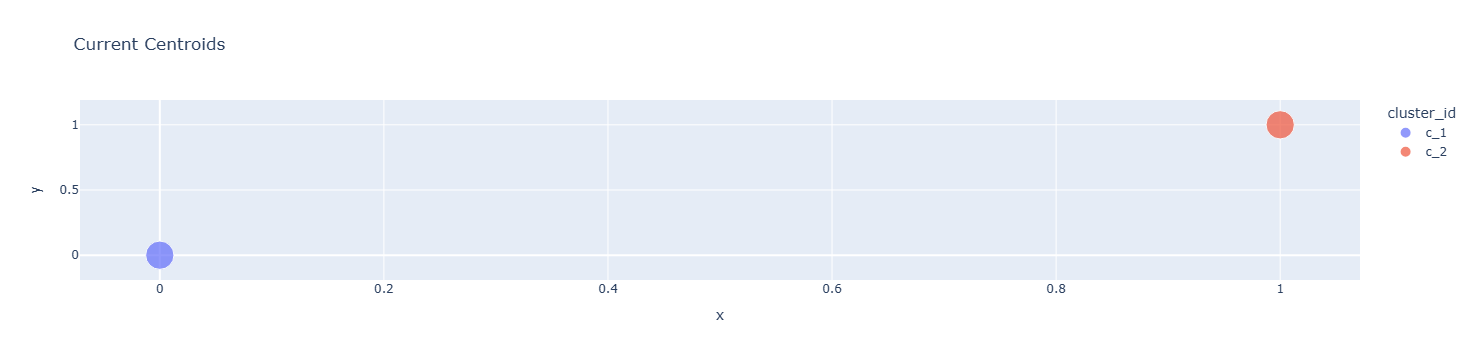

In [28]:
plot_model(stkm)

In [31]:
new_batch = sc.parallelize([Vectors.dense([0.0, 0.0])])

In [32]:
stkm.update(new_batch, decayFactor=alpha, timeUnit='batches')

25/01/06 13:19:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/06 13:19:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


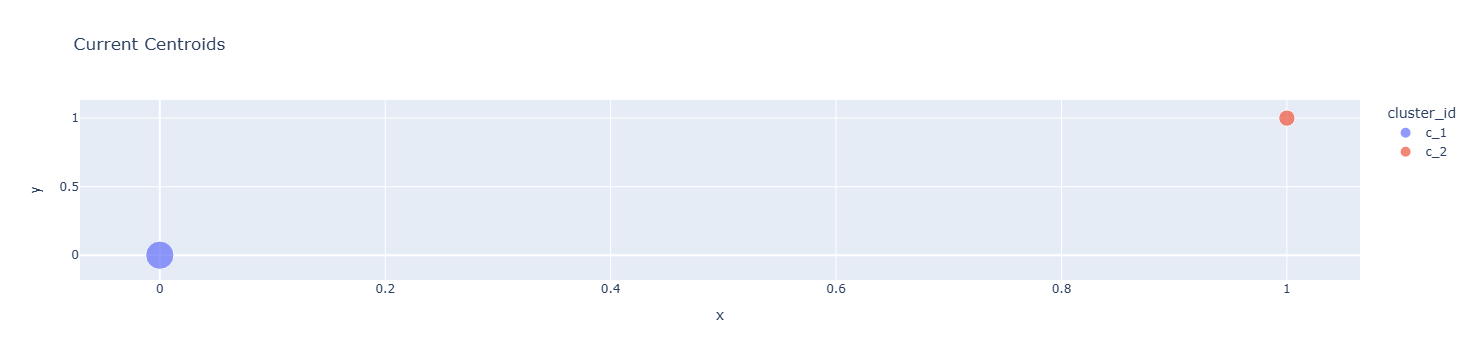

In [33]:
plot_model(stkm)

You can add more cells here to see how the clusters develop over more batches and using different decay factors, etc.
Note that this `StreamingKMeansModel` implements a deterministic approach for replacement of subcritical clusters. It minimally perturbs the largest cluster to split it.

For those interested, consider the following excerpt from the source code (Scala, PySpark 3.5.4, `org.apache.spark.mllib.clustering.StreamingKMeansModel`):

```scala
// Check whether the smallest cluster is dying. If so, split the largest cluster.
    val (maxWeight, largest) = clusterWeights.iterator.zipWithIndex.maxBy(_._1)
    val (minWeight, smallest) = clusterWeights.iterator.zipWithIndex.minBy(_._1)
    if (minWeight < 1e-8 * maxWeight) {
      logInfo(s"Cluster $smallest is dying. Split the largest cluster $largest into two.")
      val weight = (maxWeight + minWeight) / 2.0
      clusterWeights(largest) = weight
      clusterWeights(smallest) = weight
      val largestClusterCenter = clusterCenters(largest)
      val smallestClusterCenter = clusterCenters(smallest)
      var j = 0
      while (j < dim) {
        val x = largestClusterCenter(j)
        val p = 1e-14 * math.max(math.abs(x), 1.0)
        largestClusterCenter.asBreeze(j) = x + p
        smallestClusterCenter.asBreeze(j) = x - p
        j += 1
      }
    }
```

In [37]:
stkm.update(sc.parallelize([Vectors.dense([1.0, 0.0])]), decayFactor=alpha, timeUnit='batches')

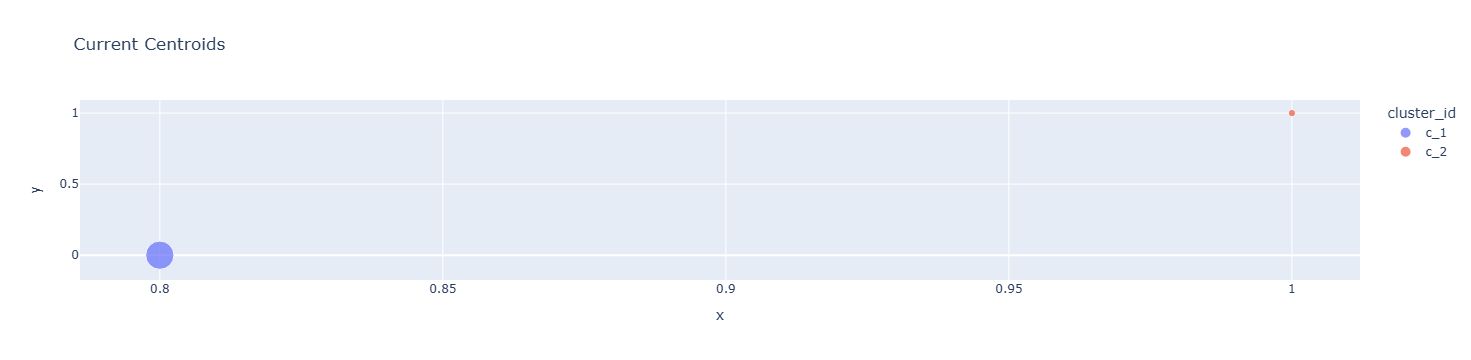

In [38]:
plot_model(stkm)

In [ ]:
sc.stop()